## **Demonstration of Quantum Circuits Learning for Spoken Commands Recognition**

*   See how quantum convolution works on recorded speech commands

*June 9, 2021, from 8:00-10:00, ICASSP local time in Eastern Daylight Time*

Huck will be on the job market for an academic or industry position in 2022. 

In [1]:
!pip install pydub
!pip install librosa

In [ ]:
from google.colab import output as colab_output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment
import IPython.display as ipd
import librosa

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""


def record(seconds=1):
    display(ipd.Javascript(RECORD))
    print(f"Recording started for {seconds} seconds.")
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return librosa.load(filename)


waveform, sample_rate = record()
ipd.Audio(waveform, rate=sample_rate)

<IPython.core.display.Javascript object>

Recording started for 1 seconds.
Recording ended.


In [2]:
! git clone https://github.com/huckiyang/QuantumSpeech-QCNN

Cloning into 'QuantumSpeech-QCNN'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 509 (delta 89), reused 21 (delta 7), pack-reused 358
Receiving objects: 100% (509/509), 878.62 MiB | 36.37 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Checking out files: 100% (41/41), done.


---- Log-Mel of Your Recorded Speech
-- Orginal sampling rate from computer's microphone 22050 Hz


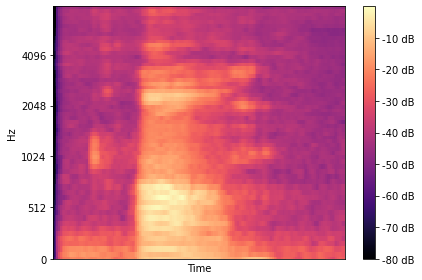

In [46]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import numpy as np

print("---- Log-Mel of Your Recorded Speech")

samp_rate = 16000
go_wav = '/content/QuantumSpeech-QCNN/Demo_and_License/huck-on.wav' 

def audio_feat(wav_path):
    y, s_sr = librosa.load(wav_path)
    mel_feat = librosa.feature.melspectrogram(y, sr=samp_rate, n_fft=1024, hop_length=128, power=1.0, n_mels=60, fmin=40.0, fmax=samp_rate/2)
    plt.figure()
    img = librosa.display.specshow(librosa.power_to_db(mel_feat, ref=np.max), y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time', fontsize=10)
    plt.tight_layout()
    return y, s_sr, mel_feat

raw_wav, ori_sr, mel_feat = audio_feat(go_wav)
print("-- Orginal sampling rate from computer's microphone", ori_sr, "Hz")


# 3. Convolution Decoding
Let's see how quantum convolution works

In [48]:
! pip install pennylane
! pip install qiskit

     |████████████████████████████████| 409kB 8.6MB/s 
  Created wheel for pennylane: filename=PennyLane-0.14.1-cp37-none-any.whl size=481980 sha256=eafa752889f23d22dc0250b92652b9edaef5a2e32f07169c917f8211a4c7c638
  Stored in directory: /root/.cache/pip/wheels/6e/a9/c9/04941d6dd58b3c111cbd1389bf63ba1b23362c137359af4626
Successfully built pennylane
     |████████████████████████████████| 6.0MB 5.8MB/s 
     |████████████████████████████████| 17.9MB 251kB/s 
     |████████████████████████████████| 204kB 47.6MB/s 
     |████████████████████████████████| 215kB 36.3MB/s 
     |████████████████████████████████| 2.1MB 26.0MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 1.0MB 43.9MB/s 
     |████████████████████████████████| 194kB 41.7MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 614kB 39.8MB/s 
     |████████████████████████████████| 3.2MB 47.6MB/s 
     |████████████████████████████████|

In [51]:
import pickle
import pennylane as qml
from pennylane import numpy as qnp
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from tqdm import tqdm
import warnings
import qiskit

n_w = 4 # numbers of wires def 4
noise_mode = False # for running at QPU

if  noise_mode == True:
    dev = qml.device('qiskit.aer', wires= n_w, noise_model=noise_model)
else:
    dev = qml.device("default.qubit", wires= n_w)

n_layers = 1

# Random circuit parameters
rand_params = np.random.uniform(high= 2 * qnp.pi, size=(n_layers, n_w)) # def 2, n_w = 4

@qml.qnode(dev)
def circuit(phi=None):
    # Encoding of 4 classical input values
    for j in range(n_w):
        qml.RY(qnp.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(n_w)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_w)]

def quanv(image, kr=2):
    h_feat, w_feat = image.shape
    """Convolves the input speech with many applications of the same quantum circuit."""
    out = np.zeros((h_feat//kr, w_feat//kr, n_w))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, h_feat, kr):
        for k in range(0, w_feat, kr):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                # kernal 3 ## phi=[image[j, k, 0], image[j, k + 1, 0], image[j, k + 2, 0], image[j + 1, k, 0], 
                # image[j + 1, k + 1, 0], image[j + 1, k +2 , 0],image[j+2, k, 0], image[j+2, k+1, 0], image[j+2, k+2, 0]]
                phi=[image[j, k], image[j, k + 1], image[j + 1, k], image[j + 1, k + 1]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_w):
                out[j // kr, k // kr, c] = q_results[c]
    return out

In [52]:
q_mel_feat = quanv(mel_feat)

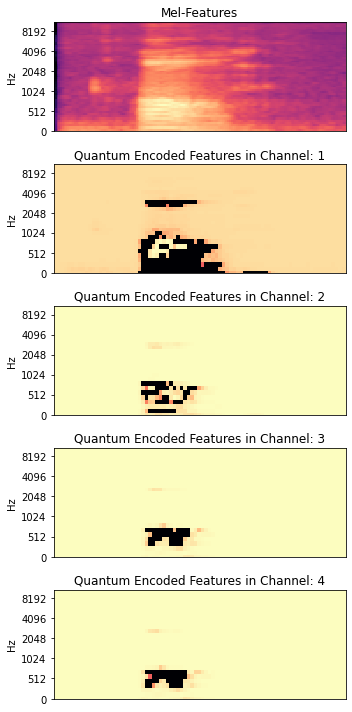

In [70]:
n_samples = 1
n_channels = 4

from pylab import rcParams
rcParams['figure.figsize'] = 5, 10


def channel_show(mel_feat, q_mel_feat):
    plt.figure()
    plt.subplot(5,  1, 1)
    librosa.display.specshow(librosa.power_to_db(mel_feat, ref=np.max), y_axis='mel')
    plt.title("Mel-Features")

    # Plot all output channels
    for c in range(n_channels):
        plt.subplot(5, 1 , c + 2)
        librosa.display.specshow(librosa.power_to_db(q_mel_feat[:,:,c], ref=np.max), y_axis='mel')
        plt.title("Quantum Encoded Features in Channel: " + str(c  + 1))

    plt.tight_layout()
    plt.show()

channel_show(mel_feat, q_mel_feat)

# NEWS: We gonna give a tutorial on, "QauntumNN for Speech and NLP" in IJCAI 2021 
https://ijcai-21.org/tutorials/

# More  Information: Learning from Quantum Data

References:
1. Cong, I., Choi, S. & Lukin, M.D. Quantum convolutional neural networks. Nat. Phys. 15, 1273–1278 (2019).

2. Tensorflow Quantum for Quantum Convolutional Neural Network
https://www.tensorflow.org/quantum/tutorials/qcnn

3. M. Henderson,  S. Shakya,  S. Pradhan,  and T. Cook,  “Quan-volutional neural networks:  powering image recognition withquantum  circuits,”Quantum Machine Intelligence,   vol.  2,no. 1, pp. 1–9, 2020